In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from scipy.signal import welch

import auxlib

In [2]:
saving_figs = os.path.join(os.getcwd(), 'figures/power_analysis_regions')
if not os.path.exists(saving_figs):
	os.makedirs(saving_figs)

saving_files = os.path.join(os.getcwd(), 'media/power_analysis_regions')
if not os.path.exists(saving_files):
	os.makedirs(saving_files)

In [3]:
def segments_average(data_segments, fs, nfft):
    Np = data_segments.shape[0] 
    Psd_per_average, Pxx, X_aver, f = auxlib.psd_percentage(data_segments[0], fs, nfft)
    for i in range(Np-1):
        Psd_per, Pxx, X_aver_n, f = auxlib.psd_percentage(data_segments[i+1], fs, nfft)
        Psd_per_average = Psd_per_average + Psd_per
        X_aver = X_aver + X_aver_n
    return Psd_per_average/Np, X_aver/Np , f
    

In [4]:
# PSD Average for each channel 
# Parameters:
# data: data for a specific session/patient, run number (3 = R3, 4 = R4, etc) and task (t1 LH, t2 RH, etc )
# data dimensions: array[channles, allsamples] exmple [64, 20000]
# t0_labels, t1_labels, t2_labels: labels of data
# fs:sample frequency
# nfft: fft length, padded with 0
# Output:
# Psd_prom_t0_per_channel, Psd_prom_t1_per_channel, Psd_prom_t2_per_channel: Power density average in % array[channels, nfft]
# X_aver/Np: FFT mod average
# f: frequency scale
# Note: Run: data, t0_labels, t1_labels, t2_labels = denoising_notch(session, task, f0, Q, fs)
# define t_left and t_right previsously


def psd_per_channels(data, t_left, t_right, t0_labels, t1_labels, t2_labels, fs, nfft):
        Psd_prom_t0_per_channel = []
        Psd_prom_t1_per_channel = []
        Psd_prom_t2_per_channel = []
        regions = {
			'frontal': [22, 38],
			'central': [1, 21],
			'temporal': [39, 46],
			'parietal': [47, 60],
			'occipital': [61, 64],
		}
        
        for i in regions['frontal']:
            data_t0, data_t1, data_t2 = auxlib.task_fragmentation(data=data,channel=i, 
                                                        t0_labels=t0_labels,
                                                        t1_labels=t1_labels, 
                                                        t2_labels=t2_labels, t_left=t_left, t_right=t_right)
            Psd_prom_t0_channel, X_prom_t0_channel, f = segments_average(data_t0, fs=160, nfft=nfft)
            Psd_prom_t1_channel, X_prom_t1_channel, f = segments_average(data_t1, fs=160, nfft=nfft)
            Psd_prom_t2_channel, X_prom_t2_channel, f = segments_average(data_t2, fs=160, nfft=nfft)
            #Adding psd_prom for each channel for each t0, t1, t2
            Psd_prom_t0_per_channel.append(Psd_prom_t0_channel)
            Psd_prom_t1_per_channel.append(Psd_prom_t1_channel)
            Psd_prom_t2_per_channel.append(Psd_prom_t2_channel)
    
        Psd_prom_t0_per_channel = np.array(Psd_prom_t0_per_channel)
        Psd_prom_t1_per_channel = np.array(Psd_prom_t1_per_channel)
        Psd_prom_t2_per_channel = np.array(Psd_prom_t2_per_channel)
    
        return Psd_prom_t0_per_channel, Psd_prom_t1_per_channel, Psd_prom_t2_per_channel, f

In [5]:
# BAND ANALYSIS

def psd_band(psd, fs, flow, fhigh):
    psd_band_vector_acc = []
    Npsd = psd.shape[1]
    Nflow = int(flow*Npsd/(fs/2))
    Nfhigh = int(fhigh*Npsd/(fs/2))
    
    for i in range(psd.shape[0]):
        sum_psd = sum(psd[i][Nflow:Nfhigh])
        psd_band_vector_acc.append(sum_psd)
        
    psd_band_vector_acc = np.array(psd_band_vector_acc)
    
    return Nflow, Nfhigh, psd_band_vector_acc

In [6]:
# flow: frequency low limit band
# fhigh: frequency high limit band

def band_analysis_run(session, task, t_left, t_right, f_cutoff_hp, flow, fhigh, nfft):
    
    data, t0_labels, t1_labels, t2_labels  = auxlib.denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)

    data_fhp = auxlib.butter_highpass_filtering_all_channels(data, order=5, f_cutoff=f_cutoff_hp, fs=fs)

    Psd_prom_t0_per_channel, Psd_prom_t1_per_channel, Psd_prom_t2_per_channel, f = psd_per_channels(data_fhp, t_left, t_right, t0_labels, t1_labels, t2_labels, fs, nfft=nfft)

    Nflow, Nfhigh, psd_band_vector_acc_t1 = psd_band(Psd_prom_t1_per_channel, fs, flow=flow, fhigh=fhigh)
    
    Nflow, Nfhigh, psd_band_vector_acc_t2 = psd_band(Psd_prom_t2_per_channel, fs, flow=flow, fhigh=fhigh)
    
    return psd_band_vector_acc_t1, psd_band_vector_acc_t2
    

In [7]:
def band_analysis_runs_mean(session, tasks, fs, tleft, t_right, f_cutoff_hp, flow, fhigh, nfft):

	psd_mean_t1 = []
	psd_mean_t2 = []
	for i in range(len(tasks)):
		psd_band_vector_acc_t1_i, psd_band_vector_acc_t2_i = band_analysis_run(session, tasks[i], t_left, t_right, f_cutoff_hp, flow, fhigh, nfft)
		total_psd_1 = np.sum(psd_band_vector_acc_t1_i)
		total_psd_2 = np.sum(psd_band_vector_acc_t2_i)
		psd_band_vector_acc_t1_i = psd_band_vector_acc_t1_i/total_psd_1
		psd_band_vector_acc_t2_i = psd_band_vector_acc_t2_i/total_psd_2

		psd_mean_t1.append(psd_band_vector_acc_t1_i)
		psd_mean_t2.append(psd_band_vector_acc_t2_i)
	
	psd_mean_t1 = np.mean(psd_mean_t1, axis=0)
	psd_mean_t2 = np.mean(psd_mean_t2, axis=0)

	return psd_mean_t1, psd_mean_t2

In [ ]:
tasks = [3, 7, 11]
channels = np.arange(1, 65, 1)
fs = 160

nfft = 4096
nperseg = 16
noverlap = 8
f_cutoff_hp = 1

t_left = 1
t_right = 3

flow=1
fhigh=4

total_mean_t1 = []
total_mean_t2 = []

for session in range(1, 88):
	session = session
	print(session)
	psd_mean_t1, psd_mean_t2 = band_analysis_runs_mean(session, tasks, fs, t_left, t_right, f_cutoff_hp, flow, fhigh, nfft)
	total_mean_t1.append(psd_mean_t1)
	total_mean_t2.append(psd_mean_t2)

total_mean_t1 = np.array(total_mean_t1)
total_mean_t2 = np.array(total_mean_t2)

total_mean_t1_1 = total_mean_t1
total_mean_t2_1 = total_mean_t2

total_std_t1 = np.std(total_mean_t1, axis=0)
total_std_t2 = np.std(total_mean_t2, axis=0)

total_mean_t1 = np.mean(total_mean_t1, axis=0)
total_mean_t2 = np.mean(total_mean_t2, axis=0)

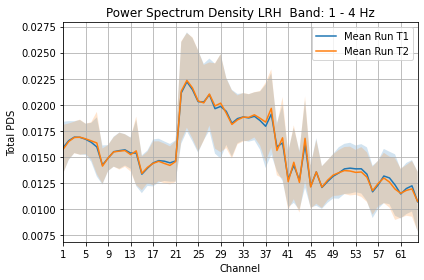

In [26]:

plt.figure()
plt.plot(channels, total_mean_t1, label = f"Mean Run T1")
plt.plot(channels, total_mean_t2, label = f"Mean Run T2")
plt.fill_between(channels, total_mean_t1 - total_std_t1, total_mean_t1 + total_std_t1, alpha=0.2)
plt.fill_between(channels, total_mean_t2 - total_std_t2, total_mean_t2 + total_std_t2, alpha=0.2)

plt.xlabel('Channel')	
plt.ylabel('Total PDS')
#plt.ylim(0, 1)
plt.xlim(1, 64)
plt.xticks(channels[::4])
plt.title(f"Power Spectrum Density LRH  Band: {flow} - {fhigh} Hz")
plt.legend()#bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(saving_figs, f"psd_mean_real_LRH_band_{flow}_{fhigh}.png"), dpi=300)
plt.show()

# Región frontal

In [23]:
def psd_per_channels(data, t_left, t_right, t0_labels, t1_labels, t2_labels, fs, nfft):
		Psd_prom_t0_per_channel = []
		Psd_prom_t1_per_channel = []
		Psd_prom_t2_per_channel = []
		regions = {
			'central': [0, 20],
			'frontal': [21, 37],
			'temporal': [38, 45],
			'parietal': [46, 59],
			'occipital': [60, 63],
		}
		
		region_ch = channels[regions['frontal'][0]:regions['frontal'][1]]
		
		for i in region_ch:
			data_t0, data_t1, data_t2 = auxlib.task_fragmentation(data=data,channel=i, 
														t0_labels=t0_labels,
														t1_labels=t1_labels, 
														t2_labels=t2_labels, t_left=t_left, t_right=t_right)
			Psd_prom_t0_channel, X_prom_t0_channel, f = segments_average(data_t0, fs=160, nfft=nfft)
			Psd_prom_t1_channel, X_prom_t1_channel, f = segments_average(data_t1, fs=160, nfft=nfft)
			Psd_prom_t2_channel, X_prom_t2_channel, f = segments_average(data_t2, fs=160, nfft=nfft)
			#Adding psd_prom for each channel for each t0, t1, t2
			Psd_prom_t0_per_channel.append(Psd_prom_t0_channel)
			Psd_prom_t1_per_channel.append(Psd_prom_t1_channel)
			Psd_prom_t2_per_channel.append(Psd_prom_t2_channel)
	
		Psd_prom_t0_per_channel = np.array(Psd_prom_t0_per_channel)
		Psd_prom_t1_per_channel = np.array(Psd_prom_t1_per_channel)
		Psd_prom_t2_per_channel = np.array(Psd_prom_t2_per_channel)
	
		return Psd_prom_t0_per_channel, Psd_prom_t1_per_channel, Psd_prom_t2_per_channel, f

In [24]:
tasks = [3, 7, 11]
channels = np.arange(1, 65, 1)
fs = 160

nfft = 4096
nperseg = 16
noverlap = 8
f_cutoff_hp = 1

t_left = 1
t_right = 3

flow=1
fhigh=4

total_mean_t1 = []
total_mean_t2 = []

for session in range(1, 88):
	session = session
	print(session)
	psd_mean_t1, psd_mean_t2 = band_analysis_runs_mean(session, tasks, fs, t_left, t_right, f_cutoff_hp, flow, fhigh, nfft)
	total_mean_t1.append(psd_mean_t1)
	total_mean_t2.append(psd_mean_t2)

total_mean_t1 = np.array(total_mean_t1)
total_mean_t2 = np.array(total_mean_t2)

total_mean_t1_1 = total_mean_t1
total_mean_t2_1 = total_mean_t2

total_std_t1 = np.std(total_mean_t1, axis=0)
total_std_t2 = np.std(total_mean_t2, axis=0)

total_mean_t1 = np.mean(total_mean_t1, axis=0)
total_mean_t2 = np.mean(total_mean_t2, axis=0)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


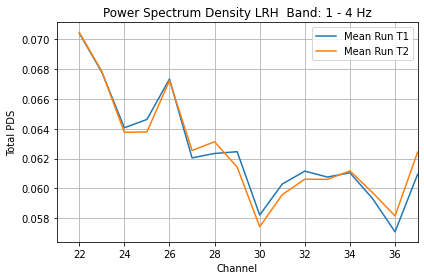

In [26]:
regions = {
	'central': [0, 20],
	'frontal': [21, 37],
	'temporal': [38, 45],
	'parietal': [46, 59],
	'occipital': [60, 63],
}

init = regions['frontal'][0]
end = regions['frontal'][1]

plt.figure()
plt.plot(channels[init:end], total_mean_t1, label = f"Mean Run T1")
plt.plot(channels[init:end], total_mean_t2, label = f"Mean Run T2")

plt.xlabel('Channel')	
plt.ylabel('Total PDS')
#plt.ylim(0, 1)
plt.xlim(init, end)
#plt.xticks(channels[::4])
plt.title(f"Power Spectrum Density LRH  Band: {flow} - {fhigh} Hz")
plt.legend()#bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(saving_figs, f"psd_mean_real_LRH_band_{flow}_{fhigh}.png"), dpi=300)
plt.show()

In [28]:
total_real_t1 = total_mean_t1
total_real_t2 = total_mean_t2


# Save data
df = pd.DataFrame(total_mean_t1)
df.to_csv(os.path.join(saving_files, f'real_mean_t1.csv'), index=False)
df = pd.DataFrame(total_mean_t2)	
df.to_csv(os.path.join(saving_files, f'real_mean_t2.csv'), index=False)


## imag


In [29]:
tasks = [4, 8, 12]
channels = np.arange(1, 65, 1)
fs = 160

nfft = 4096
nperseg = 16
noverlap = 8
f_cutoff_hp = 1

t_left = 1
t_right = 3

flow=1
fhigh=4

total_mean_t1 = []
total_mean_t2 = []

for session in range(1, 88):
	session = session
	print(session)
	psd_mean_t1, psd_mean_t2 = band_analysis_runs_mean(session, tasks, fs, t_left, t_right, f_cutoff_hp, flow, fhigh, nfft)
	total_mean_t1.append(psd_mean_t1)
	total_mean_t2.append(psd_mean_t2)

total_mean_t1 = np.array(total_mean_t1)
total_mean_t2 = np.array(total_mean_t2)

total_mean_t1_1 = total_mean_t1
total_mean_t2_1 = total_mean_t2

total_std_t1 = np.std(total_mean_t1, axis=0)
total_std_t2 = np.std(total_mean_t2, axis=0)

total_mean_t1 = np.mean(total_mean_t1, axis=0)
total_mean_t2 = np.mean(total_mean_t2, axis=0)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


In [31]:
total_imag_t1 = total_mean_t1
total_imag_t2 = total_mean_t2


# Save data
df = pd.DataFrame(total_imag_t1)
df.to_csv(os.path.join(saving_files, f'imag_mean_t1.csv'), index=False)
df = pd.DataFrame(total_imag_t2)	
df.to_csv(os.path.join(saving_files, f'imag_mean_t2.csv'), index=False)

## Comparing

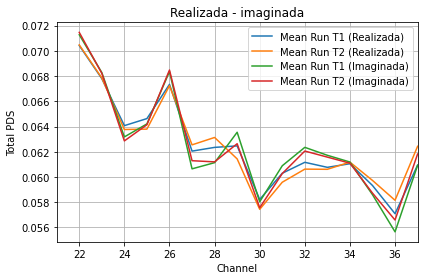

In [33]:
plt.figure()
plt.plot(channels[init:end], total_real_t1, label = f"Mean Run T1 (Realizada)")
plt.plot(channels[init:end], total_real_t2, label = f"Mean Run T2 (Realizada)")

plt.plot(channels[init:end], total_imag_t1, label = f"Mean Run T1 (Imaginada)")
plt.plot(channels[init:end], total_imag_t2, label = f"Mean Run T2 (Imaginada)")

plt.xlabel('Channel')	
plt.ylabel('Total PDS')
#plt.ylim(0, 1)
plt.xlim(init, end)
#plt.xticks(channels[::4])
plt.title(f"Realizada - imaginada")
plt.legend()#bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(saving_figs, f"psd_comparison_LRH_band_{flow}_{fhigh}.png"), dpi=300)
plt.show()